In [27]:
# Import VADER for Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create an instance of the analyzer
analyzer = SentimentIntensityAnalyzer()

In [28]:
import pandas as pd

clean_file_path = r"C:\Users\comat\GitProjects\customer-churn-ai\data\cleaned_telco_churn.csv"

try:
    df_clean = pd.read_csv(clean_file_path)
    print("Data Loaded Successfully! Sensational!")
except FileNotFoundError:
    print(f"Error: File not found at {clean_file_path}. Please check the path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")

Data Loaded Successfully! Sensational!


In [29]:
# Define a function to get the compound score (and other scores if you want)
def get_vader_sentiment(text):
    # VADER can handle NaNs or non-string types gracefully, but it's good practice
    # to ensure we're passing strings or handle potential errors if other types exist.
    if isinstance(text, str):
        return analyzer.polarity_scores(text)
    return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0} # Default for non-strings/NaN

# Apply the function to your CustomerReview column
# This will create a new Series where each item is a dictionary of scores
sentiment_scores_series = df_clean['CustomerReview'].apply(get_vader_sentiment)

# Convert the Series of dictionaries into separate columns in your DataFrame
df_sentiment_scores = pd.DataFrame(sentiment_scores_series.tolist())

# Rename columns for clarity (optional, but good practice)
df_sentiment_scores.rename(columns={
    'neg': 'VADER_Negative',
    'neu': 'VADER_Neutral',
    'pos': 'VADER_Positive',
    'compound': 'VADER_Compound'
}, inplace=True)

# Join these new sentiment score columns with original DF, Assign to a new DF
df_sentiment = pd.concat([df_clean, df_sentiment_scores], axis=1)

print("VADER sentiment scores added to the DataFrame.")

VADER sentiment scores added to the DataFrame.


In [30]:
df_sentiment[['Churn','CustomerReview', 'VADER_Negative', 'VADER_Neutral', 'VADER_Positive', 'VADER_Compound']].head()

,Churn,CustomerReview,VADER_Negative,VADER_Neutral,VADER_Positive,VADER_Compound
0,No,Really happy with my plan... no unexpected fee...,0.128,0.640,0.232,0.4201
1,No,Really happy with my plan... phone support was...,0.000,0.457,0.543,0.8588
2,Yes,"Unfortunately, my service was... frustrated by...",0.453,0.547,0.000,-0.7003
3,No,Consistently good signal... data plan is a gre...,0.000,0.539,0.461,0.8555
4,Yes,Not satisfied with the billing... billing erro...,0.372,0.628,0.000,-0.5764


In [31]:
import numpy as np

In [32]:
# Define the conditions based on the thresholds
conditions = [
    df_sentiment['VADER_Compound'] >= 0.05,   # Positive
    df_sentiment['VADER_Compound'] <= -0.05,  # Negative
    (df_sentiment['VADER_Compound'] > -0.05) & (df_sentiment['VADER_Compound'] < 0.05) # Explicitly neutral
]

# Define the corresponding sentiment labels
choices = ['Positive', 'Negative', 'Neutral']

# Create the 'Sentiment_Label' column
"""
conditions: list of our logical conditions
choices: list contains of labels we want to assign for each condition, in the same order
NumPy function applies conditions and choices. If none of the conditions are met for a row
(which shouldn't happen with these specific conditions if VADER_Compound is a valid number),
it would assign the default value.
"""
df_sentiment["Sentiment_Label"] = np.select(conditions, choices, default='Neutral')
# The default might catch any edge cases or NaNs if VADER_Compound was NaN, though our previous get_vader_sentiment handled NaNs in text.

print("\nSentiment_Labels column created based on VADER_Compound scores and added to the DataFrame.")


Sentiment_Labels column created based on VADER_Compound scores and added to the DataFrame.


---
##### Review the Distribution of Sentiment Labels

In [33]:
print("\nDistribution of Sentiment Labels:")
print(df_sentiment["Sentiment_Label"].value_counts())


Distribution of Sentiment Labels:
Sentiment_Label
Positive    5219
Negative    1548
Neutral      276
Name: count, dtype: int64


In [34]:
print("\nDistribution of Sentiment as Percentages:")
print(df_sentiment["Sentiment_Label"].value_counts(normalize=True).map(lambda x: float(f'{x:.4f}')))


Distribution of Sentiment as Percentages:
Sentiment_Label
Positive    0.7410
Negative    0.2198
Neutral     0.0392
Name: proportion, dtype: float64


In [35]:
# Display the first few rows with the new Sentiment_Label column
print("\nDataFrame with Sentiment Labels (first 5 rows):")
df_sentiment[['CustomerReview', 'VADER_Compound', 'Sentiment_Label','Churn']].head()


DataFrame with Sentiment Labels (first 5 rows):


,CustomerReview,VADER_Compound,Sentiment_Label,Churn
0,Really happy with my plan... no unexpected fee...,0.4201,Positive,No
1,Really happy with my plan... phone support was...,0.8588,Positive,No
2,"Unfortunately, my service was... frustrated by...",-0.7003,Negative,Yes
3,Consistently good signal... data plan is a gre...,0.8555,Positive,No
4,Not satisfied with the billing... billing erro...,-0.5764,Negative,Yes


##### Results:
* `Positive`: The Majority 74%. Seems common in many review datasets as customers who have a decent or good experience might be prompted to leave a review, or the service generally satisfies most.
* `Negative`: Seems small at ~22%. This could mean the service is generally very good for customers, OR it could mean I may need to revise sentiment thresholds.
* `Neutral`: Wildly small at ~4%  
---
* Remember the Reviews were populated by AI, so they are not representative of the actual product or data.
* This is for Learning Purposes
---

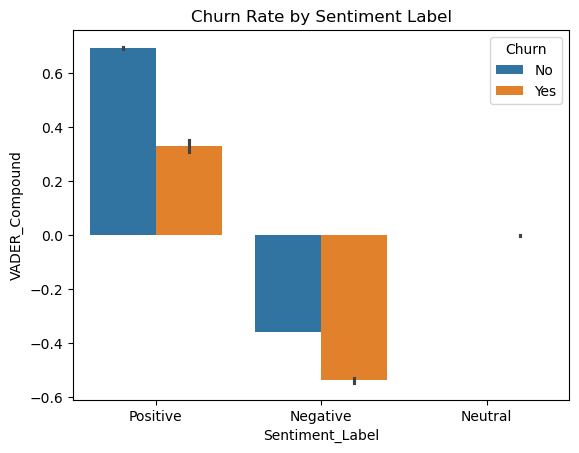

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
ax = sns.barplot(data=df_sentiment, x='Sentiment_Label', y='VADER_Compound', hue='Churn')
ax.set_title('Churn Rate by Sentiment Label')
plt.show()

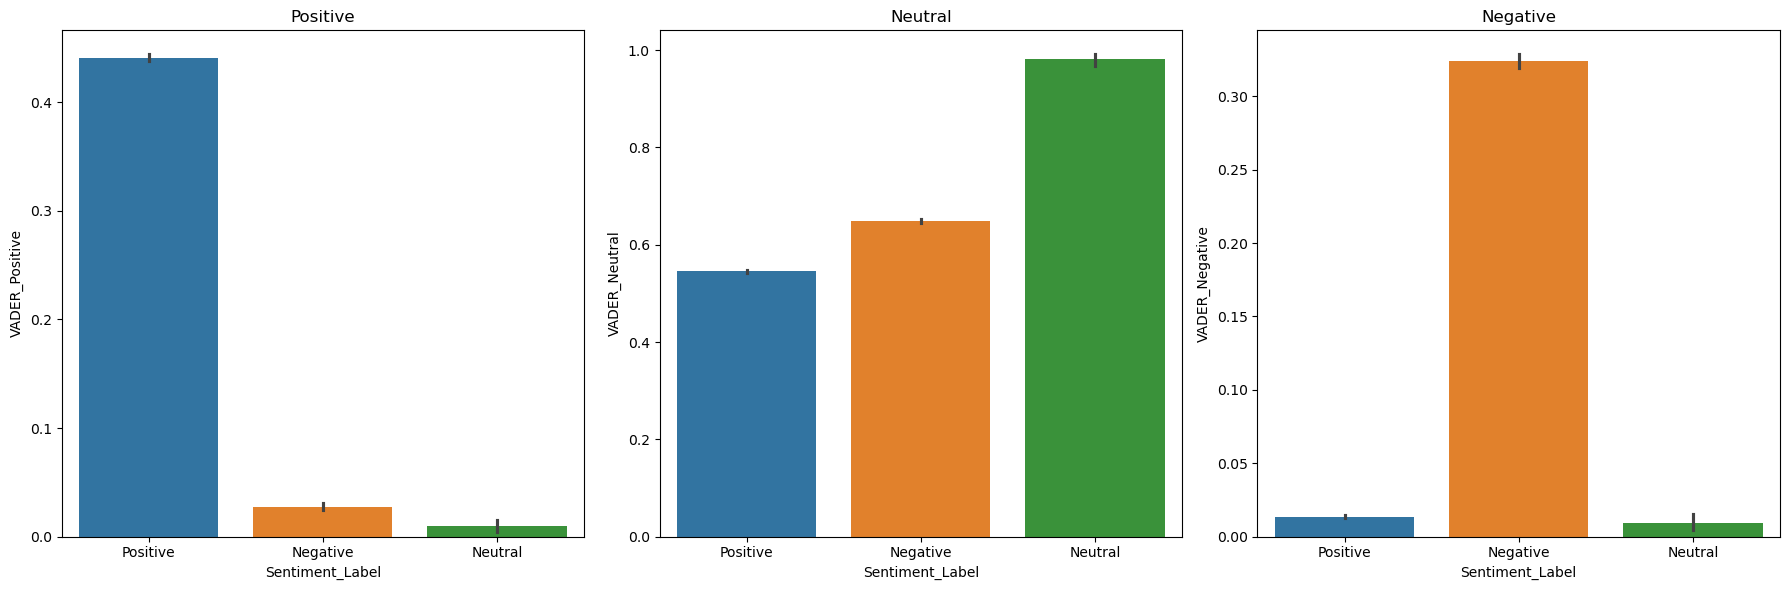

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(data=df_sentiment, x='Sentiment_Label', y='VADER_Positive', hue='Sentiment_Label', ax=ax[0])
sns.barplot(data=df_sentiment, x='Sentiment_Label', y='VADER_Neutral', hue='Sentiment_Label',ax=ax[1])
sns.barplot(data=df_sentiment, x='Sentiment_Label', y='VADER_Negative', hue='Sentiment_Label',ax=ax[2])
ax[0].set_title('Positive')
ax[1].set_title('Neutral')
ax[2].set_title('Negative')
plt.tight_layout()
plt.show()